# Applied Deep Learning Final Project
### Author: David Schemitsch (ds3300)

Many local governments aim to make data available to the public under the open data movement. However, a significant portion are released as PDFs, which makes it "available" but not in an easily accessible format like a CSV (for example: property assessment data). In this project, I aim to take a PDF of tabular data, use a convolutional neural network (CNN) to do object character recognition (OCR) on the text, and ultimately convert it to a more accessible format for analysis. This project will use as a test case the [Town of Southampton Assessment Roll](https://www.southamptontownny.gov/DocumentCenter/View/20996/Village-of-Southampton-473605), which lists assessed values for properties and their owners. An example image of the file is below.


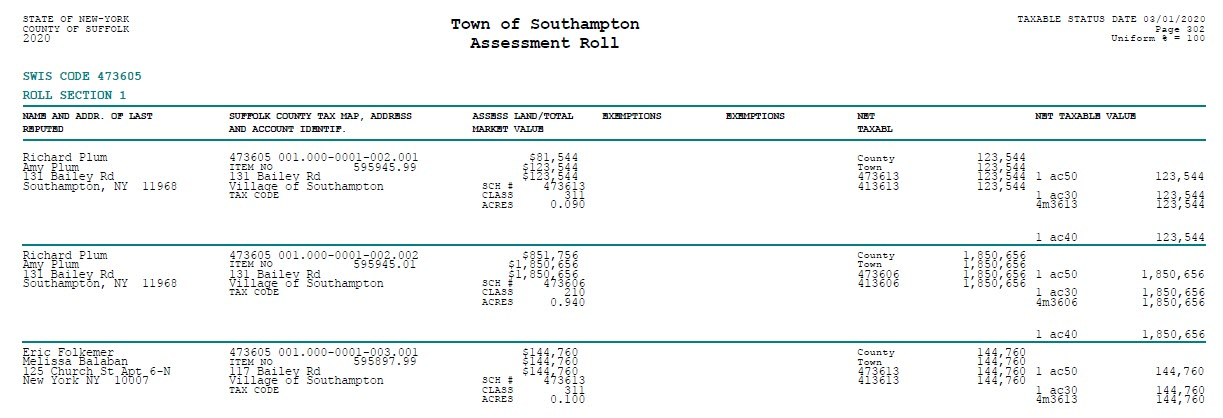

Before training a CNN to recognize text in the PDF, a large amount of preprocessing needs to be done first. The tabular structure of the image needs to be maintained in order to know what the text represents. Preprocessing is a multistep process:

1.   Identify the pixel ranges for each column by identifying the header row, and then finding out where a column begins by calculating a moving average of pixel values (if the window changes from 255 (white) to less than 255, that indicates there is text, and so, a new column).
2.   Identify the pixel ranges for each row with the same moving pixel technique. This time, use the horizontal lines in the PDF that indicate a new row. If the moving window changes from very low (representing a row of pixels in the line) to very high (representing blank space), this indicate the start of a new row.
3.   Divide up the rows into column cells by using the column start indices.
4.   Since each column cell is composed of multiple lines of text, which each indicate different information, the cells need to be divided into lines of text. Since text can overlap between lines of text (e.g. with letters like 'g' that hang below the line), the moving average technique isn't sufficient. Here, I identify the coutours of the letters using the `cv2` package, determine which is the first letter as defined by being closest to the top-left hand corner of the image, and then assign the remaining contours as being part of the first line based on whether the top contour is above the bottom contour of the first letter. This process is repeated until all contours are assigned to a line.
5.   Once the contours of the text lines are determined, the lines are broken into words based on a moving average approach (a change in the moving average indicates the start of a new word). 
6.   Finally, the letters are then identified and the bounding box surroundng the letter is extended to a dimension that will match the training set, so as to avoid distorting the image when it is processed through the model. It is important throughout this process to maintain the order of the contours so that the predicted text will make sense.

The preprocessing functions are in the `pdf_text_extraction.py` file, and the aforementioned process is wrapped up in the `extract_img_rows_and_cols` function.

#### Install packages
This project requires installation of `pdf2image` to convert a PDF into a JPEG.

In [ ]:
# Install necessary packages

!pip install pdf2image -q
!pip install s3fs -q
!pip install boto3 -q
!apt-get update --fix-missing && apt-get install poppler-utils -q

#### Load packages

In [4]:
from pdf2image import convert_from_path, convert_from_bytes
from IPython.display import display, Image
import matplotlib.pyplot as plt
import os
import pandas as pd
import s3fs
import boto3
import sys
from PIL import Image
import numpy as np
import tensorflow as tf
from google.colab.patches import cv2_imshow
import cv2
import re
from PIL import Image, ImageDraw, ImageFont
from string import ascii_lowercase, ascii_uppercase

### Set image dimensions

In [6]:
# Set image dimensions
IMG_WIDTH=50
IMG_HEIGHT=70

##Create cropped image corpus

### Read in files from GitHub

In [41]:
#! rm -r adl_final_project/
! git clone https://github.com/ds3300/adl_final_project
! cp adl_final_project/pdf_text_extraction.py .

Cloning into 'adl_final_project'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 54 (delta 14), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (54/54), done.


In [8]:
import pdf_text_extraction

In [9]:
pdf_text_extraction.convert_pdf_to_jpegs(pdf_file_name='adl_final_project/Southampton 473605_2_pgs1-5.pdf')
processed_imgs = pdf_text_extraction.extract_img_rows_and_cols(
    pdf_sheet_dir='/content/pdf_sheets', cutoff=150)

Making directory /content/pdf_sheets
Converting PDF sheets to JPEGs
Reading in and converting JPEGs (5/5)

Extracting image rows and columns (5/5)

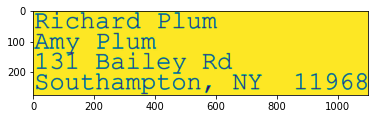

In [10]:
# Display example of one row-column cell
plt.imshow(processed_imgs[0][1].get('col0'))

##Create training data set from generated text images

One benefit of creating a model to recognize machine text is that it is possible to generate a large training set of labeled data. The training data for the model is generated from 12 fonts. I originally only used the Courier font that most closely matched the font in the PDF, but tests showed that incorporating multiple fonts allowed the model to learn more general representations of the text, which acted as a sort of data augmentation. 500 images per glyph per font were generated, each having a small random effect of positioning, font size, or partially observed adjacent glyphs to best represent the image data from the PDF.

In [11]:
# All of the potential glyphs in the image
glyphs = list('ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz1234567890-#,.$')

font_size = 80

In [12]:
symbol_dict = {
    "$": "dollar",
    "\\": "back_slash",
    "/": "forward_slash",
    "‘": "single_left_quote",
    "?": "question_mark",
    "’": "single_right_quote",
    "“": "double_left_quote",
    "!": "exclamation_mark",
    "”": "double_right_quote",
    "(": "left_parens",
    "%": "percent",
    ")": "right_parens",
    "[": "left_bracket",
    "#": "hash",
    "]": "right_bracket",
    "{": "left_curly_brace",
    "@": "at_symbol",
    "}": "right_curly_brace",
    "/": "forward_slash",
    "&": "ampersand",
    "\\": "back_slash",
    "<": "less_than",
    "-": "hyphen",
    ":": "colon",
    ";": "semicolon",
    ",": "comma",
    ".": "period",
    "*": "star",
    "'": "single_quote",
    '"': "double_quote"
}

In [14]:
import sys
np.random.seed(1)

# NOTE: takes about 30 minutes to create the training set with 500 
#       examples per font per glyph. The training set was not saved due to 
#       the size of the training set and the time needed to export it. The 
#       random seed should ensure the same set of images is created each time.

# Create directory for initial glyph images

if "text_images" not in os.listdir("/content"):
    print('Making directory /content/text_images')
    os.mkdir("/content/text_images")
else:
    print('Removing and making directory /content/text_images')
    os.system("rm -r /content/text_images")
    os.mkdir("/content/text_images")

if "original" not in os.listdir("/content/text_images"):
    print('Making directory /content/text_images/original')
    os.mkdir("/content/text_images/original")
else:
    print('Removing and making directory /content/text_images/original')
    os.system("rm -r /content/text_images/original")
    os.mkdir("/content/text_images/original")

if "train_test_images" not in os.listdir("/content/text_images"):
    print('Making directory /content/text_images/train_test_images')
    os.mkdir("/content/text_images/train_test_images")
else:
    print('Removing and making directory /content/text_images/train_test_images')
    os.system("rm -r /content/text_images/train_test_images")
    os.mkdir("/content/train_test_images")

print("Progress:")

# Loop through the glyphs and create an image for each
for g_idx, g in enumerate(glyphs):
    g = str(g)
    progress = "\r  " + g + "  (" + str(g_idx+1) + "/" + str(len(glyphs)) + ")"

    sys.stdout.write(progress)
    sys.stdout.flush()
        
    im = Image.new("RGB", (IMG_WIDTH, IMG_HEIGHT), "white")
    d = ImageDraw.Draw(im)
    d.text(xy=(0, 0), text=g, fill="black", anchor="ms", 
           font=ImageFont.truetype('adl_final_project/CourierPrime-Regular.ttf', 80))
        
    if g in symbol_dict.keys():
        g_fn = symbol_dict.get(g)
    else:
        g_fn = g

    if g in ascii_lowercase:
        prefix_fn = 'lower_'
    elif g in ascii_uppercase:
        prefix_fn = 'upper_'
    elif g in '0123456789':
        prefix_fn = 'digit_'
    else:
        prefix_fn = 'symbol_'

    fn = os.path.join("/content", "text_images", "original", prefix_fn+g_fn+".jpeg")
        
    im.save(fn)

    os.mkdir("/content/text_images/train_test_images/"+prefix_fn+g_fn)

    for idx, f in enumerate(os.listdir('adl_final_project')):
        #print(f)
        if re.search(pattern='ttf$', string=f):
            ttf = os.path.join('adl_final_project', f)
            #print(ttf)
        else:
            continue
        
        if g in '1li$':
            n = 1000
        else:
            n = 500

        # Loop through each glyph and make a directory of 2000 images
        for i in range(n):
            if g in 'gjpqy':
                y_adj=10
            else:
                y_adj=0
            
            im = Image.new("RGB", (IMG_WIDTH,IMG_HEIGHT), "white")
            d = ImageDraw.Draw(im)
            font_size = np.random.randint(low=60, high=80)
            font_i = ImageFont.truetype(ttf, font_size)
            
            g1 = glyphs[np.random.randint(0, len(glyphs))]
            g3 = glyphs[np.random.randint(0, len(glyphs))]
            msg = g1+g+g3
            w, h = d.textsize(msg, font = font_i)
            w1, h1 = d.textsize(g1, font = font_i)
            w2, h2 = d.textsize(g, font = font_i)
            x_adj = (w/2)-(w1+(w2/2))
            x_noise = np.random.randint(low=-4, high=4)
            y_noise = np.random.randint(low=-6, high=6)
            # Adjust position of the central glyph so that it its fully visible
            # within the frame - this accounts for fonts that are not monospaced,
            # where the left or right glyph may push the central glyph out of frame.
            d.text(xy=((IMG_WIDTH/2)-(w/2)+x_adj+x_noise,(IMG_HEIGHT/2)-(h/2)-y_adj+y_noise), 
                text=msg, fill="black", 
                anchor='mm',
                font = font_i)

            fn = os.path.join("/content/text_images/train_test_images", prefix_fn+g_fn, prefix_fn+g_fn+"_"+"{:02d}".format(idx)+"{:05d}".format(i)+".jpeg")
            im.save(fn)

print("\r  "+'All done')

Removing and making directory /content/text_images
Making directory /content/text_images/original
Making directory /content/text_images/train_test_images
Progress:
  All done


Below are a few examples of the randomly generated 'H' glyphs that show different font styles, font sizes, glyph position, and adjacent text in the frame.

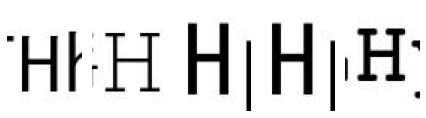

In [15]:
# Display a few examples of "H"
H_dir = os.listdir("/content/text_images/train_test_images/upper_H/")

fig, ax = plt.subplots(nrows=1, ncols=5)
for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    idx = np.random.randint(low = 0, high = len(H_dir))
    H_path = os.path.join("/content/text_images/train_test_images/upper_H/",H_dir[idx])
    H_img = Image.open(H_path)
    H_img = np.array(H_img)
    plt.imshow(H_img)
    plt.axis("off")

fig.tight_layout(pad = 1.0)


##Train the OCR model

###Read in train/test set

In [16]:
batch_size = 32
print(IMG_HEIGHT)
print(IMG_WIDTH)
data_dir = "/content/text_images/train_test_images/"

70
50


In [17]:
# https://www.tensorflow.org/tutorials/load_data/images

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  labels='inferred',
  label_mode='int',
  validation_split=0.2,
  subset="training",
  shuffle=True,
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=batch_size)

Found 426000 files belonging to 67 classes.
Using 340800 files for training.


In [18]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  labels='inferred',
  label_mode='int',
  validation_split=0.2,
  subset="validation",
  shuffle=True,
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=batch_size)

Found 426000 files belonging to 67 classes.
Using 85200 files for validation.


In [19]:
# Save the class labels
class_names_df = pd.DataFrame({'class_names':train_ds.class_names})
class_names_df.to_csv('class_names_df.csv')
from google.colab import files
files.download("class_names_df.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

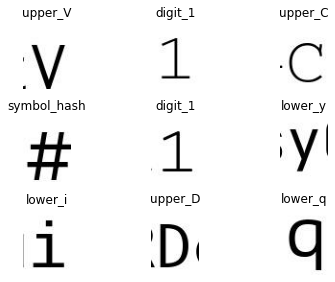

In [20]:
# Take in one 32 image batch and display the first image and label
fig, ax = plt.subplots(nrows=3, ncols=3)
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.title(train_ds.class_names[labels[i]])
    plt.imshow(images[i].numpy().astype("uint8"))
    #plt.title(class_names[labels[i]])
    plt.axis("off")
fig.tight_layout(pad = 1.0)

###Create and train the model

In [24]:
# Model source: https://www.tensorflow.org/tutorials/images/data_augmentation
from tensorflow.keras import layers

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(height=IMG_HEIGHT, width=IMG_WIDTH),
  layers.experimental.preprocessing.Rescaling(1./255, input_shape = (IMG_HEIGHT, IMG_WIDTH, 3))
])

In [25]:
num_classes = len(os.listdir("/content/text_images/train_test_images"))

model = tf.keras.Sequential([
  resize_and_rescale,
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes)
])

In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

In [28]:
# Train the model. Takes about 15 minutes with GPU enabled
tf.random.set_seed(1)

epochs = 5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
10650/10650 [==============================] - 210s 19ms/step - loss: 0.3447 - accuracy: 0.9044 - val_loss: 0.0364 - val_accuracy: 0.9852
Epoch 2/5
10650/10650 [==============================] - 203s 19ms/step - loss: 0.0338 - accuracy: 0.9869 - val_loss: 0.0228 - val_accuracy: 0.9905
Epoch 3/5
10650/10650 [==============================] - 214s 20ms/step - loss: 0.0235 - accuracy: 0.9904 - val_loss: 0.0177 - val_accuracy: 0.9923
Epoch 4/5
10650/10650 [==============================] - 210s 20ms/step - loss: 0.0182 - accuracy: 0.9924 - val_loss: 0.0175 - val_accuracy: 0.9933
Epoch 5/5
10650/10650 [==============================] - 208s 20ms/step - loss: 0.0155 - accuracy: 0.9939 - val_loss: 0.0256 - val_accuracy: 0.9911


In [ ]:
# Save the model for predicting at a later date.
model.save('content/model_cnn')
!zip -r content/model_cnn.zip content/model_cnn
from google.colab import files
files.download("content/model_cnn.zip")
import json
model_hist = history.history
json.dump(model_hist, open('model_history', 'w'))

INFO:tensorflow:Assets written to: content/model1_20201218/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Data Science MS Notes/Applied DL/Final Project/model1_20201218/assets
updating: content/model1_20201218/ (stored 0%)
updating: content/model1_20201218/saved_model.pb (deflated 89%)
updating: content/model1_20201218/assets/ (stored 0%)
updating: content/model1_20201218/variables/ (stored 0%)
updating: content/model1_20201218/variables/variables.data-00000-of-00001 (deflated 13%)
updating: content/model1_20201218/variables/variables.index (deflated 67%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Optionally import previously trained model

In [42]:
model = tf.keras.models.load_model('/content/adl_final_project/model')
model.summary()
labels = pd.read_csv("/content/adl_final_project/class_names_20201218.csv")
history = json.load(open('/content/adl_final_project/model_history', 'r'))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 70, 50, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 68, 48, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 34, 24, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 22, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 11, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 9, 32)         9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 4, 32)         

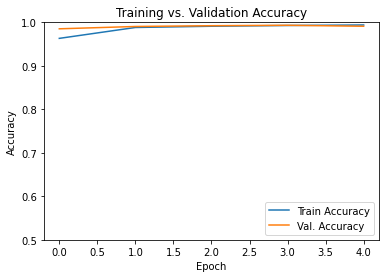

In [48]:
history_df = pd.DataFrame(history)
plt.plot(history_df['accuracy'], label='Train Accuracy')
plt.plot(history_df['val_accuracy'], label = 'Val. Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title("Training vs. Validation Accuracy")
plt.show()

In [49]:
# Model has a high accuracy
val_loss, val_acc = model.evaluate(val_ds, verbose=2)

2663/2663 - 31s - loss: 0.0225 - accuracy: 0.9917


#### Predict on one image

In [50]:
# Use the component functions of get_image_text to show how one column cell
# is broken up into its hierarchy of images

my_img=processed_imgs[0][1].get('col0')

contour_l = pdf_text_extraction.get_char_contours(img=my_img)
bb_coord_l = pdf_text_extraction.make_bb_coord_l(contour_l=contour_l, img=my_img, 
                                                 IMG_HEIGHT=IMG_HEIGHT)
max_height = np.amin([pdf_text_extraction.char_max_height(bb_coords=bb_coord_l, IMG_HEIGHT=IMG_HEIGHT),
                          IMG_HEIGHT])
max_width = np.amin([pdf_text_extraction.char_max_width(bb_coords=bb_coord_l, IMG_WIDTH=IMG_WIDTH),
                         IMG_WIDTH])

isolated_text_example=pdf_text_extraction.sort_bb_coords(
    bb_coords=bb_coord_l,img=my_img, 
    max_height=max_height,max_width=max_width,
    IMG_HEIGHT=70)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


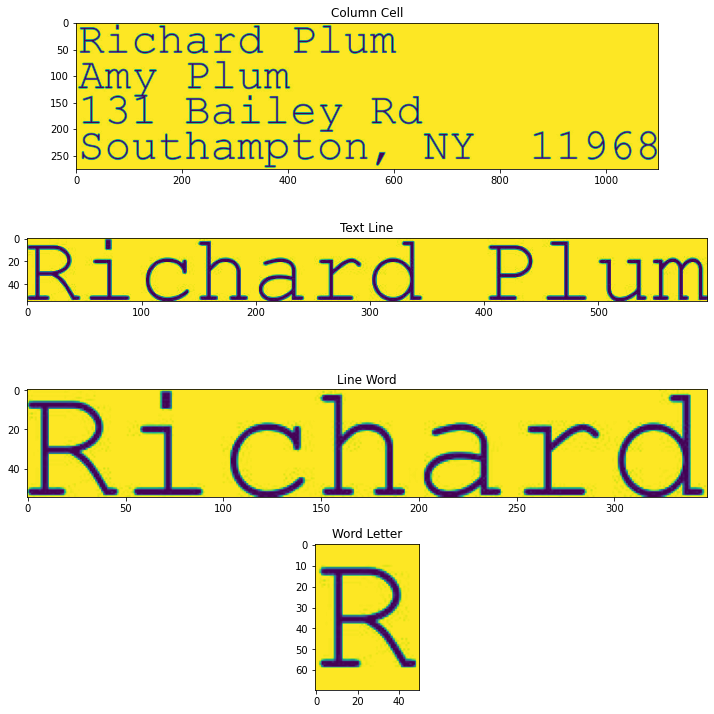

In [107]:
# Show nested structure of column cell -> text line -> line word -> word letter
H_dir = os.listdir("/content/text_images/train_test_images/upper_H/")

img_titles = ['Column Cell','Text Line','Line Word','Word Letter']
img_dict = {'Column Cell':my_img,
            'Text Line':isolated_text_example.get('whole_line0'),
            'Line Word':isolated_text_example.get('line_words0')[0],
            'Word Letter':isolated_text_example.get('line_words_letters0')[0][0]}

fig, ax = plt.subplots(nrows=4, ncols=1, figsize = (10,10))
for i, t in enumerate(img_titles):
    ax = plt.subplot(4, 1, i + 1)
    text_img = img_dict.get(t)
    plt.imshow(text_img)
    plt.title(t)
fig.tight_layout(pad = 1.0)

A prediction test shows that the model is not 100% accurate on real world data. The model has trouble telling the difference between lowercase and uppercase versions of letters that have similar shapes (e.g. 'c' and 'C', 'o' and 'O'). Other problem shapes are lowercase 'L', numeric '1', and lowercase 'I', given their similar shapes.

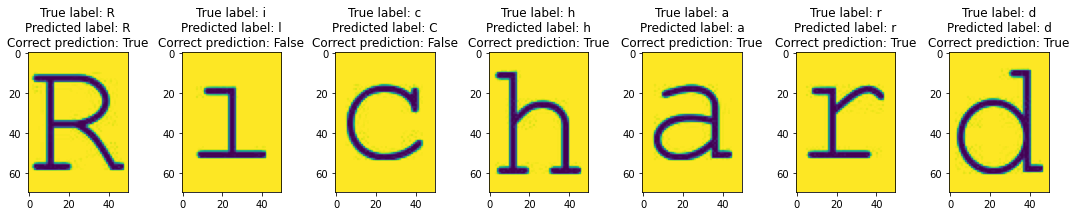

In [116]:
# Demonstration of predicting the labels of the letters in a single word
example_batch=pdf_text_extraction.assemble_pred_batch(isolated_text_example.get('line_words_letters0')[0], 
                                                  70, 50)

preds=model.predict(example_batch)
scores = tf.nn.softmax(preds)
pred_labels=labels.class_names.str.extract('(\w$)').loc[np.argmax(scores, axis=1)]

true_labels = 'Richard'

fig, ax = plt.subplots(nrows=1, ncols=len(pred_labels), figsize = (15,15))
for i in range(len(pred_labels)):
    ax = plt.subplot(1, len(pred_labels), i + 1)
    true_label = true_labels[i]
    pred_label = pred_labels.iloc[i,0]
    if true_label==pred_label:
        label_match = 'True'
    else:
        label_match = 'False'
    title = 'True label: '+true_label+'\nPredicted label: '+pred_label+'\nCorrect prediction: '+label_match
    plt.title(title)
    plt.imshow(isolated_text_example.get('line_words_letters0')[0][i])

fig.tight_layout(pad = 1.0)


## Extract PDF text and convert to data frame

Getting from the processed PDF image to a DataFrame takes a few additional steps:

*   `get_image_text` isolates the lines, words, and letters in each column cell and returns the softmax predicted label for each letter image in a series of lists.
*   `reorganize_doc_text` takes in the previous output and converts it into a dictionary format. The feature names for the text are inferred based on the line order and anticipated text formatting through regular expressions. For example, the address line for city, state, and zip code expects a 5-digit number at the end of the line, so a regular expression is used to identify it.
*   `doc_text_to_dataframe` converts the dictionary into a data frame for easier analysis.





In [117]:
doc_text = pdf_text_extraction.get_image_text(
    processed_imgs=processed_imgs, 
    IMG_HEIGHT=70, IMG_WIDTH=50,
    model=model, labels=labels)

Extracting image text (1/5)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Extracting image text (5/5)

In [118]:
doc_text_reorganized=pdf_text_extraction.reorganize_doc_text(doc_text=doc_text)

In [24]:
doc_df=pdf_text_extraction.doc_text_to_dataframe(doc_text_reorganized)

In [25]:
doc_df.head()

,owner_name1,owner_name2,owner_name3,owner_name4,owner_street_addr,owner_city,owner_state,owner_zip,account,item_no,property_addr,assessed_land,assessed_total,total_market_value,school_no,class_no,acres,net_taxable_county,net_taxable_town,net_taxable_school
0,RlChard Plum,Amy Plum,NaN,NaN,13l Balley Rd,SOuthamptOn,NY,11968,473605 0010000001002001,59594599,131 BalleV Rd Vlllaqe Of SOuthamptOn,r81544,r123544,r123544,473613,311,0090,NaN,NaN,NaN
1,RlChard Plum,Amy Plum,NaN,NaN,13l Balley Rd,SOuthamptOn,NY,11968,473605 0010000001002002,59594501,131 BalleV Rd Vlllaqe Of SOuthamptOn,r1r885501765566,r1850656,SCH h 473606,473606,210,0940,1850656,1850656,1850656
2,ErlC FOlkemer,Mellssa Balaban,NaN,NaN,125 ChurCh St Apt 6N,New YOrk,NY,10007,473605 0010000001003001,59589799,117 BalleV Rd Vlllaqe Of SOuthamptOn,r144760,r144760,r144760,473613,311,0100,144760,144760,144760
3,ErlC FOlkemer,Mellssa Balaban,NaN,NaN,125 ChurCh St Apt 6N,New YOrk,NY,10007,473605 0010000001003002,59589701,117 BalleV Rd Vlllaqe Of SOuthamptOn,r1r557639704400,r1563740,SCH h 473606,473606,210,0400,1563740,1563740,1563740
4,Andy Lee,NaN,NaN,NaN,91 Balley Rd,SOuthamptOn,NY,11968,473605 0010000001005003,59587398,91 BalleV Rd Vlllaqe Of SOuthamptOn,r721400,r721400,r721400,473613,311,0260,NaN,NaN,NaN


## Conclusion
The OCR model performed fairly well on the PDF images based on visual inspection of the results. As previously mentioned, there are some specific characters that the model confuses. This could be corrected by adding additional training data for frequently incorrect letters or adding additional layers to the model. The validation accuracy of the model was already very high, however, so it may be the case that the training data does not adequately represent the extracted images from the PDF. Perhaps additional data augmentation (random crops, rotation, etc.) could lead to better performance gains on the PDF images. Post-prediction, rules-based text cleanup might help correct some of the mistakes as well. For instance, convert predicted uppercase letters in the middle of words to lowercase (`COCCOOn` -> `Coccoon`).